In this notebook I will implement and discuss the example in https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Pairs%20Trading%20with%20Machine%20Learning%22.ipynb

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint
from scipy import stats
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline, returns

pipeline

In [2]:
def make_pipeline():
    industry=morningstar.asset_classification.morningstar_industry_group_code.latest
    financial_health=morningstar.asset_classification.financial_health_grade.latest
    pipe_columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'industry': industry,
        'financial_health': financial_health
    }
    pipe_screen=(QTradableStocksUS()&financial_health.notnull()&(~industry.eq(31055)))
    pipe=Pipeline(screen=pipe_screen,columns=pipe_columns)
    return pipe

In [3]:
start_date='2016-1-1'
end_date='2017-12-31'

In [4]:
output=run_pipeline(make_pipeline(),end_date,end_date)
output

Market Cap financial_health  \
2018-01-02 00:00:00+00:00 Equity(2 [ARNC])                 4                C   
                          Equity(24 [AAPL])                4                A   
                          Equity(31 [ABAX])                2                B   
                          Equity(41 [ARCB])                2                C   
                          Equity(52 [ABM])                 3                C   
                          Equity(53 [ABMD])                4                B   
                          Equity(62 [ABT])                 4                B   
                          Equity(64 [ABX])                 4                B   
                          Equity(67 [ADSK])                4                B   
                          Equity(76 [TAP])                 4                B   
                          Equity(110 [ACXM])               3                A   
                          Equity(114 [ADBE])               4                A   
                          Equity(122 [ADI])                4                C   
                          Equity(128 [ADM])                4                B   
                          Equity(154 [AEM])                4                B   
                          Equity(161 [AEP])                4                B   
                          Equity(166 [AES])                4                C   
                          Equity(185 [AFL])                4                B   
                          Equity(197 [AGCO])               3                B   
                          Equity(216 [HES])                4                C   
                          Equity(239 [AIG])                4                C   
                          Equity(247 [AIN])                3                A   
                          Equity(253 [AIR])                2                B   
                          Equity(266 [AJG])                4                A   
                          Equity(289 [MATX])               2                C   
                          Equity(300 [ALK])                4                C   
                          Equity(301 [ALKS])               4                A   
                          Equity(311 [ALOG])               2                A   
                          Equity(337 [AMAT])               4                A   
                          Equity(351 [AMD])                4                C   
...                                                      ...              ...   
                          Equity(50430 [LW])               4                B   
                          Equity(50444 [LEXE_A])           3                D   
                          Equity(50499 [EVHC])             3                D   
                          Equity(50509 [ICHR])             2                C   
                          Equity(50518 [ATH])              4                C   
                          Equity(50526 [LGF_A])            4                D   
                          Equity(50533 [CNDT])             3                C   
                          Equity(50534 [HGV])              3                A   
                          Equity(50535 [PK])               4                C   
                          Equity(50537 [WRD])              3                D   
                          Equity(50595 [BIVV])             4                B   
                          Equity(50606 [VREX])             2                C   
                          Equity(50612 [FRAC])             3                C   
                          Equity(50616 [ANAB])             3                C   
                          Equity(50633 [JAG])              3                B   
                          Equity(50634 [JELD])             3                C   
                          Equity(50636 [REVG])             3                C   
                          Equity(50639 [LAUR])             3                C   


Cast the financial_health data into numbers

In [5]:
def change_to_score(grade):
    if grade=='A':
        return 0.1
    elif grade=='B':
        return 0.3
    elif grade=='C':
        return 0.7
    elif grade=='D':
        return 0.9
    else:
        return 1.0

In [6]:
output['financial_health']=output['financial_health'].apply(change_to_score)

In [7]:
asset_list=output.index.levels[1].unique()

In [8]:
asset_returns= returns(asset_list,start_date,end_date)

In [9]:
asset_returns=asset_returns.dropna(axis=1)

In [10]:
asset_returns.shape

(503, 2039)

Do PCA on returns of assets 

In [11]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(asset_returns)

PCA(copy=True, n_components=50, whiten=False)

In [12]:
pca.components_.shape

(50, 2039)

The space where we do clustering will be two years return (reduced to 50 by PCA) + market cap + financial health grade

In [13]:
asset_financial_health=output.loc[output.index.levels[0][0]]['financial_health']
asset_market_cap=output.loc[output.index.levels[0][0]]['Market Cap']

In [14]:
X=np.hstack((pca.components_.T,
             asset_financial_health[asset_returns.columns].values.reshape((2039,1)),
             asset_market_cap[asset_returns.columns].values.reshape((2039,1))))

In [15]:
X = preprocessing.StandardScaler().fit_transform(X)

In [16]:
clf = DBSCAN(eps=1.5, min_samples=3)
clf.fit(X)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

The number of clusters is the number of unique labels except -1 (wandering points)

In [17]:
len(set(clf.labels_)) - (1 if -1 in clf.labels_ else 0)

11

The count of each cluster

plot the accumulative returns of some clusters

In [22]:
clustered_series = pd.Series(index=asset_returns.columns, data=clf.labels_.flatten())

In [23]:
clustered_series.value_counts()

-1     1972
 0       21
 1        8
 4        7
 2        6
 6        5
 9        4
 3        4
 10       3
 8        3
 7        3
 5        3
dtype: int64

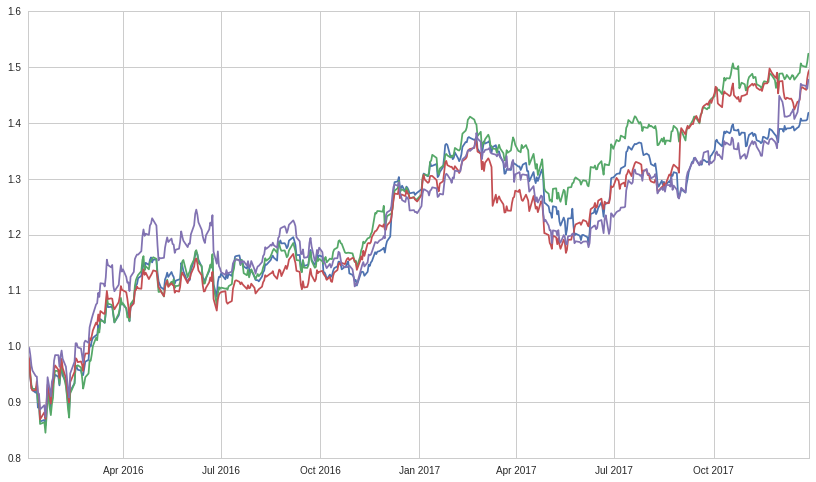

In [305]:
plt.figure()
for s in clustered_series[clustered_series==9].index:
    plt.plot(np.cumprod(asset_returns[s]+1))
plt.show()

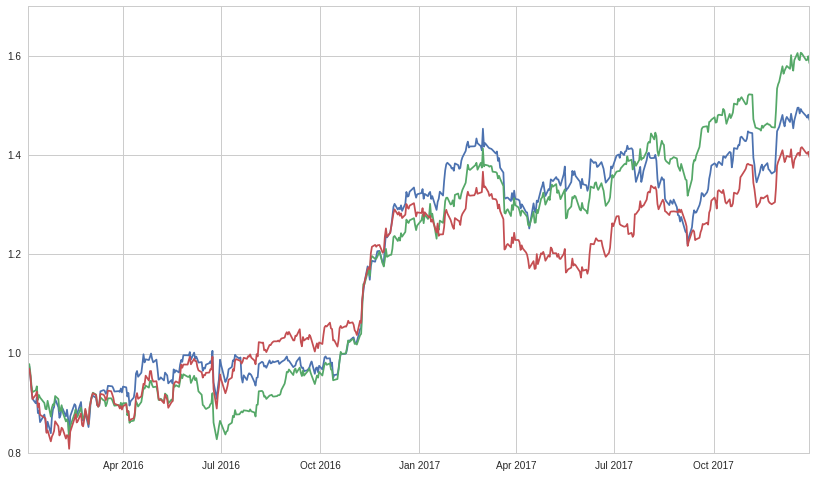

In [303]:
plt.figure()
for s in clustered_series[clustered_series==5].index:
    plt.plot(np.cumprod(asset_returns[s]+1))
plt.show()

We use T-SNE algorithm (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to visualize these high dimensional data

In [25]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

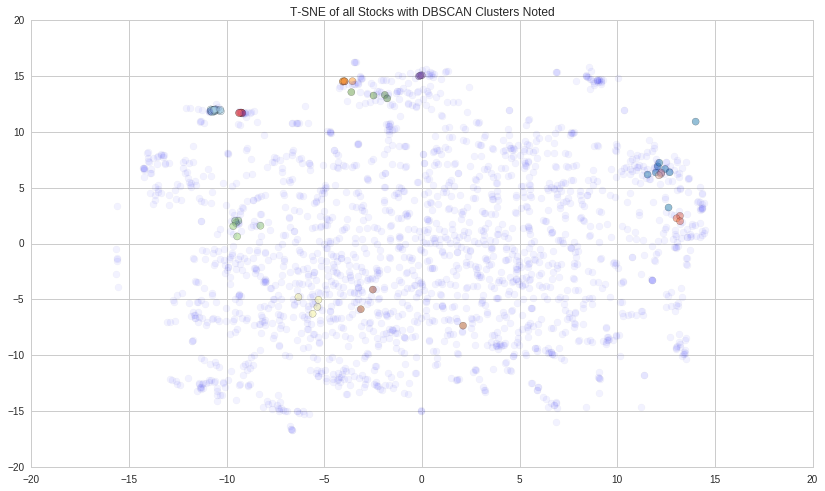

In [55]:
plt.figure(1, facecolor='white')
#plot clustered points
plt.scatter(
    X_tsne[(clf.labels_!=-1), 0],
    X_tsne[(clf.labels_!=-1), 1],
    s=50,
    alpha=0.5,
    c=clf.labels_[clf.labels_!=-1],
    cmap=cm.Paired
)
#plot background points
plt.scatter(
    X_tsne[(clf.labels_==-1), 0],
    X_tsne[(clf.labels_==-1), 1],
    s=50,
    alpha=0.05
)
plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');